In [13]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import pandas as pd

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
credentials = ServiceAccountCredentials.from_json_keyfile_name(
    "../../gckey.json",
    [
        "https://spreadsheets.google.com/feeds",
        "https://www.googleapis.com/auth/drive",
    ],
)
client = gspread.authorize(credentials)
spreadsheet = client.open("MaLA data mixing ablation")
Stagnant_SIB = spreadsheet.worksheet("Stagnant-SIB-200")

In [16]:
Stagnant_SIB_Data = Stagnant_SIB.get_all_records(value_render_option="UNFORMATTED_VALUE")
df_Stagnant_SIB = pd.DataFrame(Stagnant_SIB_Data, columns=Stagnant_SIB_Data[0])

In [17]:
languages = ['tha_Thai', 'yor_Latn', 'sna_Latn', 'wol_Latn']
df_selected = df_Stagnant_SIB[['Model'] + languages]

In [18]:
df_long = df_selected.melt(id_vars='Model', var_name='Language', value_name='Score')

resource_map = {
    # 'eng_Latn': 'High',
    'tha_Thai': 'Mid',
    'yor_Latn': 'Mid',
    'sna_Latn': 'Low',
    'wol_Latn': 'Low'
}
df_long['Resource_Level'] = df_long['Language'].map(resource_map)

In [19]:
def extract_base(model_name):
    if 'Llama-2-7B' in model_name:
        return 'Llama-2-7B'
    elif 'Llama-3.1-8B' in model_name:
        return 'Llama-3.1-8B'
    elif 'Viking-7B' in model_name:
        return 'Viking-7B'
    else:
        return 'Other'
    
def extract_data_combination(model_name):
    if 'Bilingual-Code' in model_name:
        return 'Bilingual-Code'
    elif 'Bilingual' in model_name:
        return 'Bilingual'
    elif 'Monolingual-Code' in model_name:
        return 'Monolingual-Code'
    elif 'Monolingual' in model_name:
        return 'Monolingual'
    else:
        return 'Unknown'

df_long['Base_Model'] = df_long['Model'].apply(extract_base)
df_long['Data_Combination'] = df_long['Model'].apply(extract_data_combination)

In [20]:
df_agg = df_long.groupby(['Base_Model','Data_Combination','Resource_Level'], as_index=False)['Score'].mean()

data_combination_order = ['Bilingual', 'Bilingual-Code', 'Monolingual', 'Monolingual-Code']
resource_order = ['Mid','Low']
base_model_order = ['Llama-2-7B','Llama-3.1-8B','Viking-7B']

df_agg['Data_Combination'] = pd.Categorical(df_agg['Data_Combination'], categories=data_combination_order, ordered=True)
df_agg['Resource_Level'] = pd.Categorical(df_agg['Resource_Level'], categories=resource_order, ordered=True)

/tmp/ipykernel_1044312/657663230.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  lineplot = sns.lineplot(


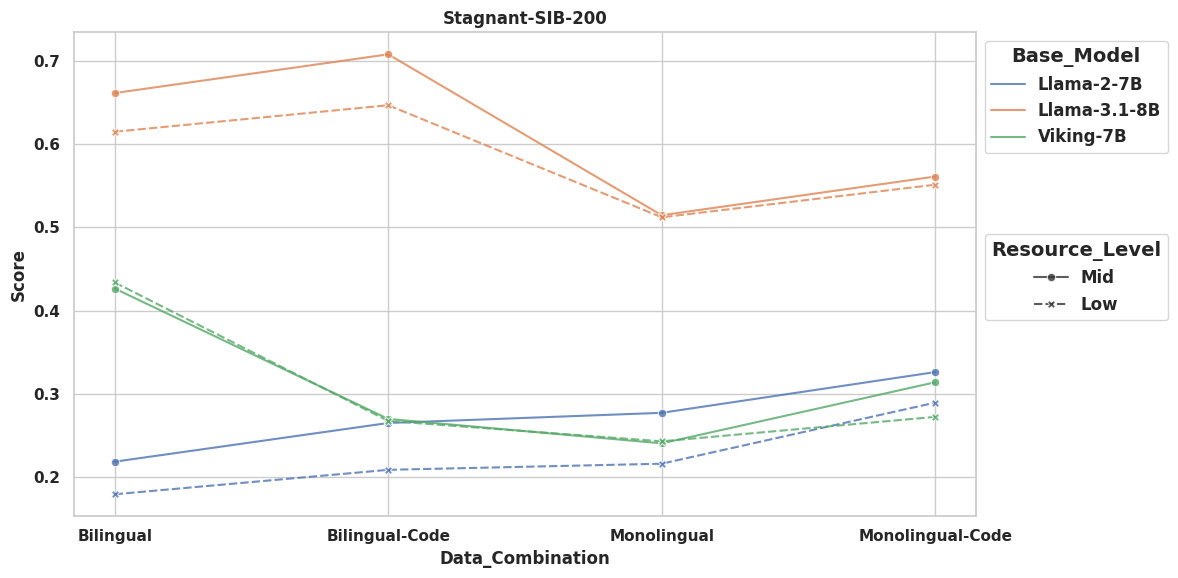

In [21]:
plt.figure(figsize=(12,6))
lineplot = sns.lineplot(
    data=df_agg,
    x='Data_Combination',
    y='Score',
    hue='Base_Model',        
    style='Resource_Level',  
    markers=True,
    dashes=True,
    ci=None,
    hue_order=base_model_order,
    style_order=resource_order,
    linewidth=1.5, 
    alpha=0.8  
)

plt.title('Stagnant-SIB-200')
plt.xticks(rotation=0)

handles, labels = lineplot.get_legend_handles_labels()

base_handles = []
base_labels = []
style_handles = []
style_labels = []

for handle, label in zip(handles, labels):
    if label in base_model_order:
        base_handles.append(handle)
        base_labels.append(label)
    elif label in resource_order:
        style_handles.append(handle)
        style_labels.append(label)

lineplot.legend_.remove()

plt.subplots_adjust(right=0.7)

legend_base = plt.legend(
    base_handles, base_labels, 
    title='Base_Model', 
    bbox_to_anchor=(1.0, 1), 
    loc='upper left'
)
plt.gca().add_artist(legend_base)

plt.legend(
    style_handles, style_labels, 
    title='Resource_Level',
    bbox_to_anchor=(1.0, 0.6),
    loc='upper left'
)


plt.tight_layout()
plt.show()

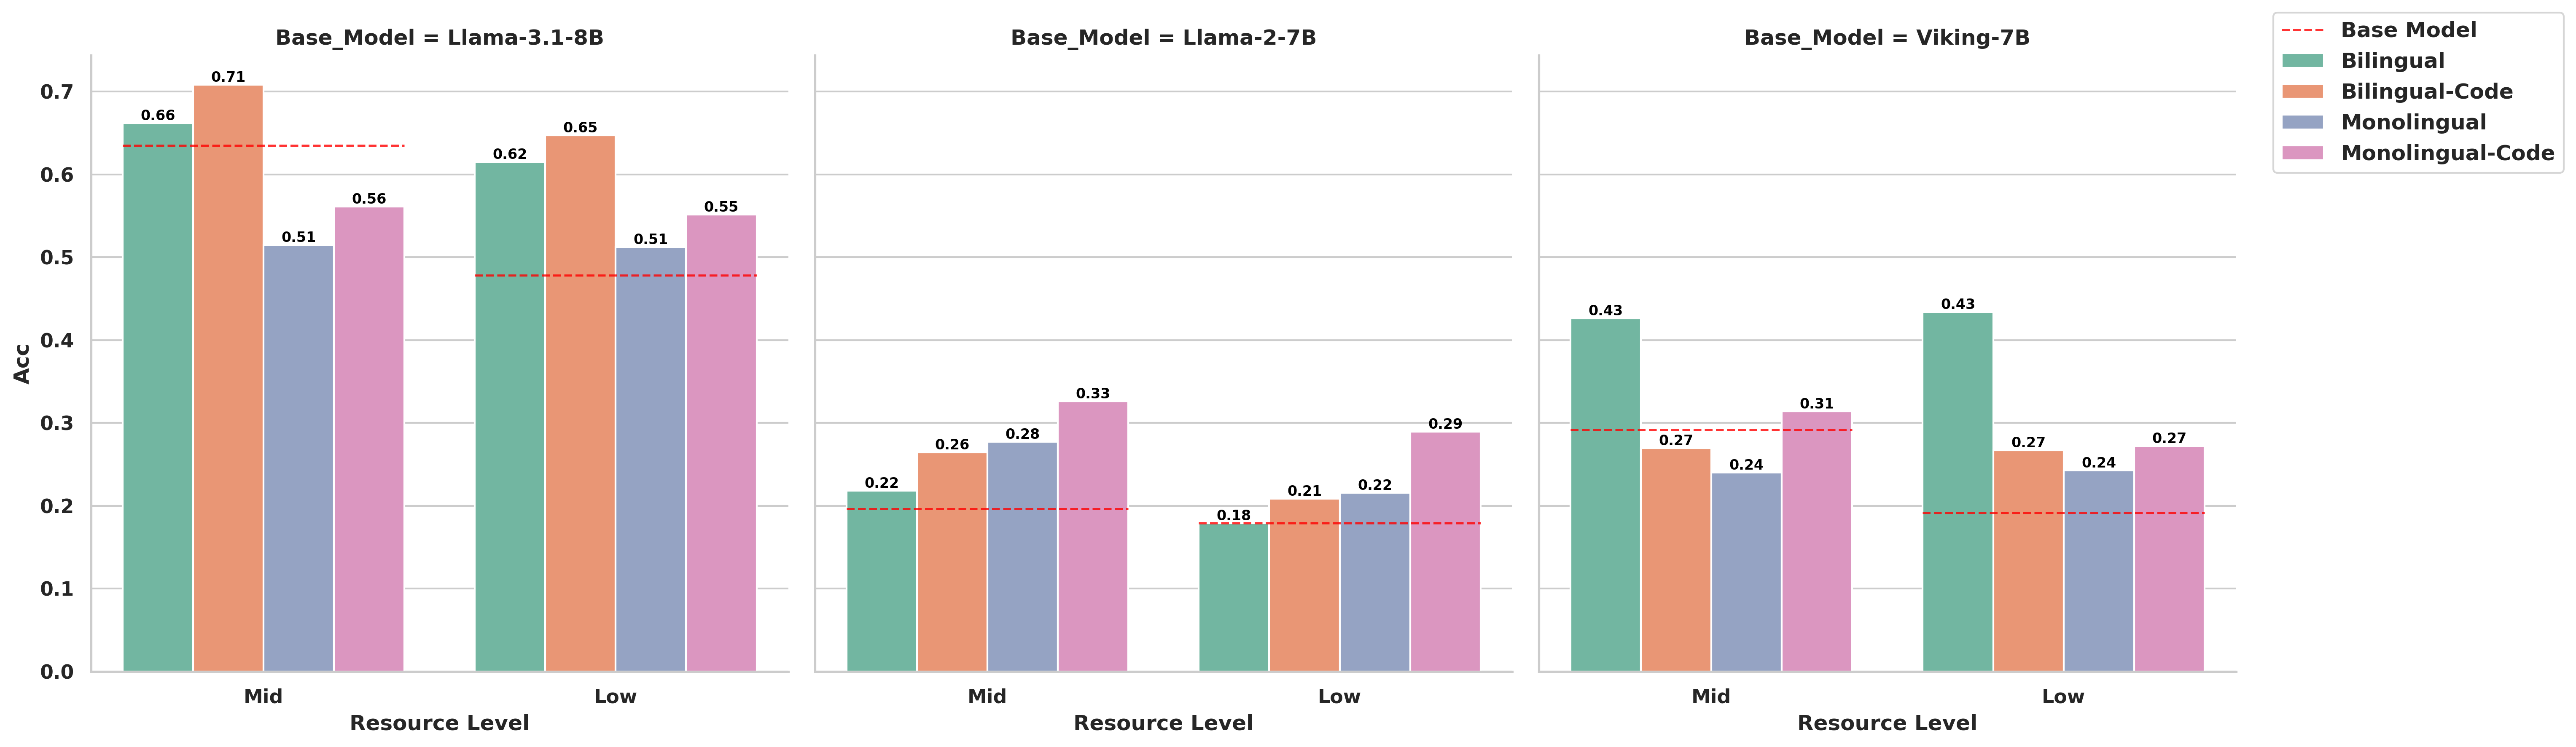

In [22]:
df = df_agg[df_agg["Base_Model"].isin(["Llama-3.1-8B", "Llama-2-7B", "Viking-7B"])]
custom_order = ['Llama-3.1-8B', 'Llama-2-7B', 'Viking-7B']
df['Base_Model'] = pd.Categorical(df['Base_Model'], categories=custom_order, ordered=True)
df = df.sort_values(by='Base_Model')
base_lines = {
    # ("Llama-3.1-8B", "High"): 0.7843,
    ("Llama-3.1-8B", "Mid"): 0.6348,
    ("Llama-3.1-8B", "Low"): 0.4780,   
    # ("Llama-2-7B", "High"): 0.4020,
    ("Llama-2-7B", "Mid"): 0.1961,
    ("Llama-2-7B", "Low"): 0.1790,
    # ("Viking-7B", "High"): 0.3235,
    ("Viking-7B", "Mid"): 0.2917,
    ("Viking-7B", "Low"): 0.1912,
}

sns.set_theme(style="whitegrid")

# Set font size and weight globally
plt.rcParams.update({
    'font.size': 14,          # Increase font size
    'font.weight': 'bold',    # Make font bold
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'legend.fontsize': 12,
    'legend.title_fontsize': 14
})

g = sns.catplot(
    data=df,
    x="Resource_Level",
    y="Score",
    hue="Data_Combination",
    col="Base_Model",
    kind="bar",
    palette="Set2",
    sharey=True,
    legend_out=False,
)

g.fig.set_size_inches(18, 6)
g.fig.set_dpi(300)
g.set_axis_labels("Resource Level", "Acc")


base_models = ["Llama-3.1-8B", "Llama-2-7B", "Viking-7B"]
for ax, model in zip(g.axes.flat, base_models):
    xtick_positions = ax.get_xticks()
    xtick_labels = [tick.get_text() for tick in ax.get_xticklabels()]

    for x, level_str in zip(xtick_positions, xtick_labels):
        val = base_lines[(model, level_str)]
        ax.hlines(
            y=val,
            xmin=x - 0.4,
            xmax=x + 0.4,
            color="red",
            linestyles="--",
            linewidth=1.2,
            alpha=0.8,
            # label=f"{model}-{level_str} base={val}"
            label="Base Model",
        )

    for bar in ax.patches:
        height = bar.get_height()
        if height > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f'{height:.2f}',
                ha='center',
                va='bottom',
                color='black',
                fontweight='bold',
                fontsize=8
            )

all_handles, all_labels = [], []
for ax in g.axes.flat:
    h, l = ax.get_legend_handles_labels()
    all_handles.extend(h)
    all_labels.extend(l)

if g._legend:
    g._legend.remove()

unique_handles, unique_labels = [], []
for h, lbl in zip(all_handles, all_labels):
    if lbl not in unique_labels:
        unique_labels.append(lbl)
        unique_handles.append(h)

g.fig.legend(unique_handles, unique_labels, loc="upper left", bbox_to_anchor=(1, 1))
# g.fig.suptitle("SIB-200 Stagnant Languages", y=1.01)
g.savefig("SIB-200-Stagnant.pdf", format="pdf", bbox_inches="tight")
plt.tight_layout()
plt.show()

In [23]:
df_agg

,Base_Model,Data_Combination,Resource_Level,Score
0,Llama-2-7B,Bilingual,Low,0.17895
1,Llama-2-7B,Bilingual,Mid,0.21815
2,Llama-2-7B,Bilingual-Code,Low,0.20835
3,Llama-2-7B,Bilingual-Code,Mid,0.26470
4,Llama-2-7B,Monolingual,Low,0.21570
5,Llama-2-7B,Monolingual,Mid,0.27695
6,Llama-2-7B,Monolingual-Code,Low,0.28920
7,Llama-2-7B,Monolingual-Code,Mid,0.32595
8,Llama-2-7B,NaN,Low,0.17895
9,Llama-2-7B,NaN,Mid,0.19610
